This notebook explains how to run a simple 2-dimension example of Diva.<br>
The input files and the figures are created within the notebook.<br>
The reading/writing of input files is done through specific classes defined in [pydiva2d](./pydiva2d.py).

In [3]:
import os
import logging
import shutil
import subprocess
import numpy as np
import importlib
import pydiva2d

In [36]:
importlib.reload(pydiva2d)

<module 'pydiva2d' from '/home/ctroupin/Projects/SeaDataCloud/Python/pydiva2d.py'>

# Setup 

## Logging configuration

The *logging* is already configured in *pydiva2d*.<br>
Replace 'DEBUG' by 'INFO', 'WARNING' or 'ERROR'.

In [5]:
logger = logging.getLogger('diva2D')
logger.setLevel(logging.DEBUG)

Set the path to the Diva installation you want to work with.

In [6]:
divadir = "/home/ctroupin/Software/DIVA/diva-4.7.1"

## Directories

Create variables storing the Diva directories.

In [7]:
DivaDirs = pydiva2d.DivaDirectories(divadir)

INFO:diva2D:Diva main directory: /home/ctroupin/Software/DIVA/diva-4.7.1
INFO:diva2D:Creating Diva directory paths
INFO:diva2D:Diva binary directory: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/bin
INFO:diva2D:Diva source directory: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/src/Fortan
INFO:diva2D:Diva 2D directory: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped
INFO:diva2D:Diva 4D directory: /home/ctroupin/Software/DIVA/diva-4.7.1/JRA4/Climatology
INFO:diva2D:Diva 4D input directory: /home/ctroupin/Software/DIVA/diva-4.7.1/JRA4/Climatology/input


Create variables storing the Diva input and output files.

In [8]:
DivaFiles = pydiva2d.Diva2Dfiles(DivaDirs.diva2d)

INFO:diva2D:Creating Diva 2D file names and paths
INFO:diva2D:Contour file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/coast.cont
INFO:diva2D:Parameter file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/param.par
INFO:diva2D:Data file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/data.dat
INFO:diva2D:Valatxy file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/valatxy.coord
INFO:diva2D:Result file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/output/ghertonetcdf/results.nc
INFO:diva2D:Mesh file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/meshgenwork/fort.22
INFO:diva2D:Mesh topo file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/meshgenwork/fort.23


# Prepare the input files

## Contour

Create a sequence of points representing the contour (no crossing, no duplicate points, etc).<br>
It is not necessary to close the contour (i.e., setting the last point equal to the first point).<br>
Each coordinate (lon, lat) is defined as a [ndarray](https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html).

In [9]:
lon = np.array([[0., 2., 2., 0.], [2.5, 6., 6., 2.5]])
lat = np.array([[0., 0., 4., 4.], [0., 0., 3., 3.]]) 

Create a **contour** object using the coordinates: 

In [10]:
contour2D = pydiva2d.Diva2DContours(lon, lat)

INFO:diva2D:Creating Diva 2D contour object


and write its content to the corresponding file defined in the **DivaFile** object:

In [12]:
contour2D.write_to(DivaFiles.contour)

INFO:diva2D:Number of contours: 2
INFO:diva2D:Number of contours: 2
DEBUG:diva2D:Sub-contour no. 1 has 4 points
DEBUG:diva2D:Sub-contour no. 2 has 4 points
INFO:diva2D:Written contours into file /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/coast.cont


## Data

Create arrays of coordinates (*x*, *y*), values (*z*) and optionnaly weights (*w*) representing the data points.<br>
If the weights are not specified, it is assumed that all the data points have an identical weight (equal to 1).

In [13]:
x = np.array((1.2, 1.75, 3., 5.5))  
y = np.array((2.1, 3.5, 2., 0.2))
z = np.array((1., -2., 4, -1))
w = np.array((1., 1., 0.5, 0.5))

Similarly to the contour, we create a **data** object:

In [14]:
data2D = pydiva2d.Diva2DData(x, y, z, w)

INFO:diva2D:Creating Diva 2D data object
INFO:diva2D:Setting weights to data points


and we write the values to the specified file:

In [15]:
data2D.write_to(DivaFiles.data)

INFO:diva2D:Written data into file /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/data.dat


## Parameters

We need to set the parameters defining the domain and the analysis parameters.

In [16]:
xmin, ymin, nx, ny, dx, dy = 0.0, 0.0, 61, 81, 0.1, 0.05

In [17]:
CorrelationLength = 1.5
SignalToNoiseRatio = 0.5
VarianceBackgroundField = 1.0
ExclusionValue = -999.
iCoordChange = 0
iSpec = 11
iReg = 0

We create a **parameter** object that stores all the parameter values:

In [18]:
parameters2D = pydiva2d.Diva2DParameters(CorrelationLength, iCoordChange, iSpec, iReg, xmin, ymin, dx, dy, nx, ny,
                                ExclusionValue, SignalToNoiseRatio, VarianceBackgroundField)

INFO:diva2D:Creating Diva 2D parameter object


and we write them into a file:

In [20]:
parameters2D.write_to(DivaFiles.parameter)

INFO:diva2D:Written parameters into file /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/param.par


## List of extra points

In the optional input file *valatxy.coord*, one can specify additional locations where the interpolation has to be performed.<br>
Here we ask for the analysis at the location of the first two data points, plus at an additional location.

In [21]:
xcoord = np.array((1.2, 1.75, 5.9))  
ycoord = np.array((2.1, 3.5, 3.9))

We create the object **valatxy** and write the coordinates to a file:

In [22]:
valatxy = pydiva2d.Diva2DValatxy(xcoord, ycoord)
valatxy.write_to(DivaFiles.valatxy)

INFO:diva2D:Creating Diva 2D valatxy object
INFO:diva2D:Written locations into file /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/valatxy.coord


# Run Diva

Now that the input files have been created we can perform a Diva analysis.

## Mesh generation

**To do:** redicted stdin and stdout to the same log file.

In [24]:
logger.info("Starting generation of the finite-element mesh")
subprocess.Popen("./divamesh", cwd=DivaDirs.diva2d, shell=True)
logger.info("Finished generation of the finite-element mesh")

INFO:diva2D:Starting generation of the finite-element mesh
INFO:diva2D:Finished generation of the finite-element mesh


## Run the diva calculation

In [25]:
logger.info("Starting computation of the gridded field")
subprocess.Popen("./divacalc", cwd=DivaDirs.diva2d, shell=True)
logger.info("Finished computation of the gridded field")

INFO:diva2D:Starting computation of the gridded field
INFO:diva2D:Finished computation of the gridded field


# Time for some plots

We import a few more modules to plot the input files content and the results.<br>
The last line asks for the plot to be done within the notebook, not as external window.

In [26]:
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline

## Input files

Let's represent the observations, the grid and the contours.<br>
By default, each contour is represented in a different color.

DEBUG:diva2D:Adding data points to plot
DEBUG:diva2D:Adding output grid to plot


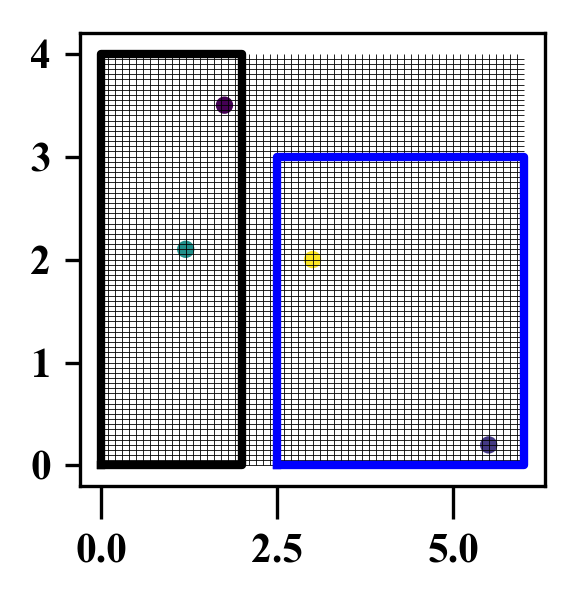

In [28]:
fig = plt.figure(figsize=(2, 2))
contour2D.add_to_plot(linewidth=2)
data2D.add_to_plot(s=10)
parameters2D.plot_outputgrid()

## Results 

The results are stored in a netCDF file that we can access using the **resultfile** property of **DivaFile** object.<br>
The field is then added to the plot. In addition we can include the locations of the observations.

DEBUG:diva2D:Adding analysed field to plot
DEBUG:diva2D:Adding data points to plot


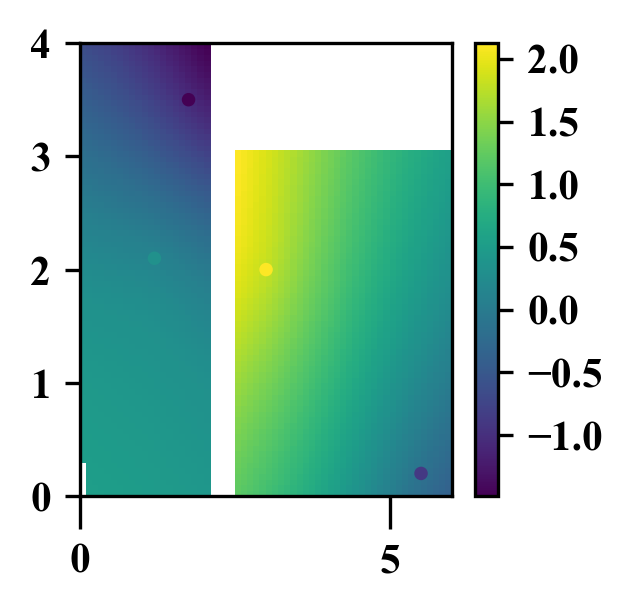

In [29]:
fig = plt.figure(figsize=(2, 2))
results2D = pydiva2d.Diva2DResults(DivaFiles.result)
results2D.add_to_plot('result')
data2D.add_to_plot(cmap=plt.cm.viridis, s=5)

The error field is represented using a similar command:

DEBUG:diva2D:Adding error field to plot
DEBUG:diva2D:Adding data positions to plot


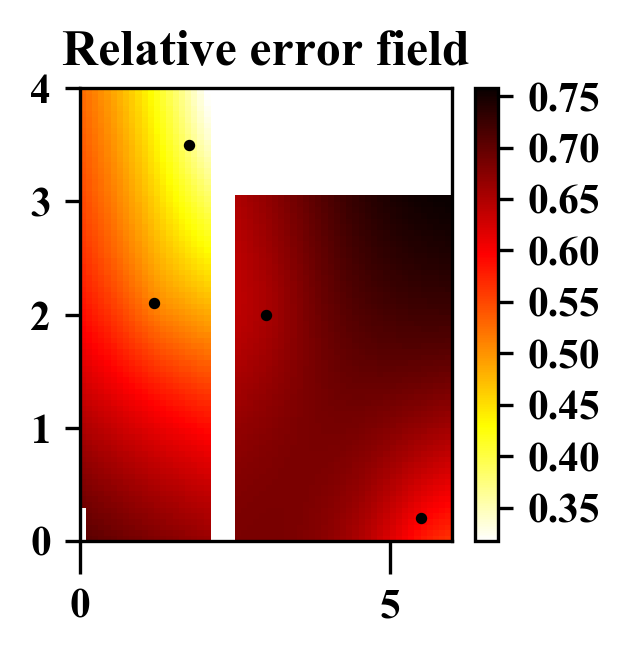

In [30]:
fig = plt.figure(figsize=(2, 2))
results2D.add_to_plot('error', cmap=plt.cm.hot_r)
data2D.add_positions_to_plot(s=3)
plt.title('Relative error field')

## Finite-element mesh

It is also interesting to display the finite-element mesh that covers our domain of interest.

In [37]:
mesh2D = pydiva2d.Diva2DMesh(DivaFiles.mesh, DivaFiles.meshtopo)

DEBUG:diva2D:Adding finite-element mesh to plot


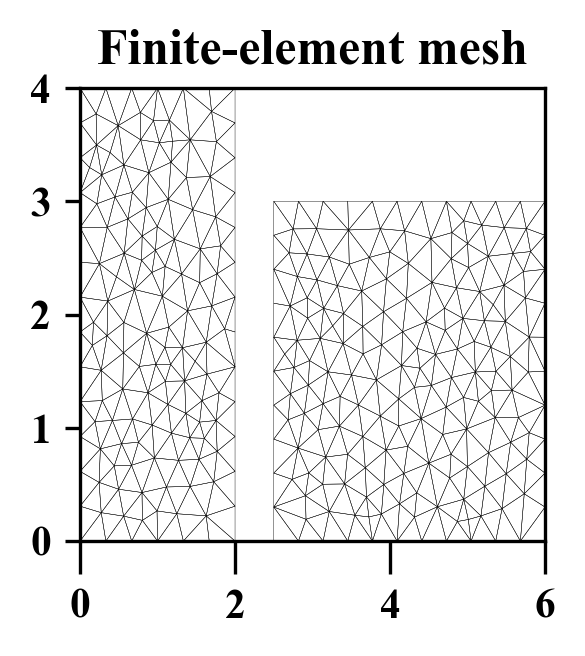

In [35]:
fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(111)
mesh2D.add_to_plot(ax, lw=0.1)
plt.title('Finite-element mesh')

In [39]:
mesh2D.describe()

INFO:diva2D:Number of nodes: 325
INFO:diva2D:Number of interfaces: 889
INFO:diva2D:Number of elements: 566
